# Dataset and Library Importation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import matplotlib.gridspec as gridspec
from matplotlib import rcParams
from scipy import stats
from matplotlib import colors
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm



print(f"Numpy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Seaborn version: {sns.__version__}")

Numpy version: 1.22.4
Pandas version: 1.5.3
Seaborn version: 0.12.2


In [2]:
import warnings
warnings.filterwarnings('ignore') ##Be careful in using this code! It makes warning invisible.

In [3]:
from google.colab import files
uploaded = files.upload()

Saving marketing_campaign_data.csv to marketing_campaign_data.csv


In [4]:
df = pd.read_csv("marketing_campaign_data.csv", sep = ',')

df.sample(5)

Unnamed: 0    ID  Year_Birth Education Marital_Status      Income  \
1147        1147  5430        1956        S1    Bertunangan  54450000.0   
454          454  6233        1976        S1        Menikah  65991000.0   
494          494  6605        1944        S3          Cerai  55614000.0   
1468        1468  7196        1950        S3        Menikah  41145000.0   
1964        1964  1158        1966        S1          Cerai  48877000.0   

      Kidhome  Teenhome Dt_Customer  Recency  ...  NumWebVisitsMonth  \
1147        1         1  14-09-2012        0  ...                  8   
454         0         1  07-09-2012       21  ...                  7   
494         0         0  27-11-2013       85  ...                  7   
1468        1         1  08-02-2014       20  ...                  3   
1964        0         1  05-01-2014       27  ...                  7   

      AcceptedCmp3  AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  \
1147             0             0             0             0             0   
454              0             0             0             0             0   
494              0             1             0             0             0   
1468             0             0             0             0             0   
1964             0             0             0             0             0   

      Complain  Z_CostContact  Z_Revenue  Response  
1147         0              3         11         0  
454          0              3         11         0  
494          0              3         11         0  
1468         0              3         11         0  
1964         0              3         11         0  

[5 rows x 30 columns]

# Feature Engineering and Exploratory Data Analysis

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           2240 non-null   int64  
 1   ID                   2240 non-null   int64  
 2   Year_Birth           2240 non-null   int64  
 3   Education            2240 non-null   object 
 4   Marital_Status       2240 non-null   object 
 5   Income               2216 non-null   float64
 6   Kidhome              2240 non-null   int64  
 7   Teenhome             2240 non-null   int64  
 8   Dt_Customer          2240 non-null   object 
 9   Recency              2240 non-null   int64  
 10  MntCoke              2240 non-null   int64  
 11  MntFruits            2240 non-null   int64  
 12  MntMeatProducts      2240 non-null   int64  
 13  MntFishProducts      2240 non-null   int64  
 14  MntSweetProducts     2240 non-null   int64  
 15  MntGoldProds         2240 non-null   i

## Feature Engineering

In [6]:
# Customer's age
df['age'] = 2023 - df['Year_Birth']

# Customer's total spending on various items
df['total_spend'] = df['MntCoke'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds']

# Living situation
df['living_with'] = df['Marital_Status'].replace({"Menikah":"Partner",
                                                  "Bertunangan":"Alone",
                                                  "Lajang":"Alone",
                                                  "Cerai":"Alone",
                                                  "Janda":"Alone",
                                                  "Duda":"Alone"})

# Number of kids in the household
df['total_children'] = df['Kidhome'] + df['Teenhome']

# Total members in the household
df["family_size"] = df["living_with"].replace({"Alone": 1, "Partner":2})+ df["total_children"]

# Customer's total transaction on varioud items
df['total_transaction'] = df['NumDealsPurchases'] + df['NumWebPurchases'] + df['NumCatalogPurchases'] + df['NumStorePurchases']

# Customer's age when joining
df['join_age'] = pd.DatetimeIndex(df['Dt_Customer']).year - df['Year_Birth']

# Whether a customer is a parent or not
is_parent = []

for x in df['total_children']:
  if x > 0:
    parent = 1
  else:
    parent = 0
  is_parent.append(parent)

df['is_parent'] = is_parent

# Customer's age group
age_group = []

for x in df['age']:
  if x >= 9 and x <= 17:
    group = 'Teen'
  elif x >= 18 and x <=30:
    group = 'Young Adult'
  elif x >= 31 and x <= 60:
    group = 'Adult'
  elif x >= 61:
    group = 'Senior'
  else:
    group = 'Untitled'
  age_group.append(group)

df['age_group'] = age_group

# How long the customer has been a member
join_period = []

df['join_year'] = pd.DatetimeIndex(df['Dt_Customer']).year

for x in df['join_year']:
  period = 2023 - x
  join_period.append(period)

df['join_period'] = join_period

# Safe div function so the result won't be infinite
def safe_div(x,y):
  if y == 0:
    return 0
  return x / y

# Adding conversion rate column
df['cvr'] = df.apply(lambda x: safe_div(x['total_transaction'], x['NumWebVisitsMonth']), axis = 1)

#For clarity
df=df.rename(columns={"MntCoke": "Coke", "MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})

#Dropping some of the redundant features
to_drop = ["Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "Unnamed: 0", "join_year"]
df = df.drop(to_drop, axis=1)

df.sample(10)

ID Education Marital_Status      Income  Kidhome  Teenhome  Recency  \
1612   9242        S1         Lajang  64509000.0        0         0       19   
1151   8310        S1    Bertunangan  68142000.0        0         1       96   
938    3673        S1         Lajang  55239000.0        0         1       59   
182   10562        S2        Menikah  66835000.0        0         0       21   
1610   6729        S1         Lajang  68655000.0        0         0       95   
872    3623        S1    Bertunangan  21675000.0        1         0       55   
1517   6310        S1        Menikah  33039000.0        1         0        4   
227     709        S1          Cerai  51537000.0        0         1       27   
1314   8789        D3        Menikah  59060000.0        1         0       77   
1515   2853        S1         Lajang  51766000.0        1         0       74   

        Coke  Fruits    Meat  ...  total_spend  living_with  total_children  \
1612  836000  185000  575000  ...      1722000        Alone               0   
1151  897000  126000  196000  ...      1459000        Alone               1   
938   371000   17000  238000  ...       779000        Alone               1   
182   620000   26000  195000  ...      1033000      Partner               0   
1610  456000   19000  832000  ...      1538000        Alone               0   
872     4000       0   16000  ...        45000        Alone               1   
1517   30000    8000   12000  ...        78000      Partner               1   
227   787000   20000  204000  ...      1103000        Alone               1   
1314   35000   40000  111000  ...       274000      Partner               1   
1515   60000   51000   87000  ...       275000        Alone               1   

      family_size  total_transaction  join_age  is_parent  age_group  \
1612            1                 19        23          0      Adult   
1151            2                 24        48          1      Adult   
938             2                 26        42          1      Adult   
182             2                 24        67          0     Senior   
1610            1                 21        24          0      Adult   
872             2                 10        38          1      Adult   
1517            3                  7        35          1      Adult   
227             2                 18        60          1     Senior   
1314            3                 14        25          1      Adult   
1515            2                 12        34          1      Adult   

      join_period        cvr  
1612           10   4.750000  
1151           11   4.000000  
938            10   5.200000  
182            10  12.000000  
1610           11   7.000000  
872             9   1.428571  
1517           10   1.400000  
227            11   2.250000  
1314            9   3.500000  
1515            9   2.400000  

[10 rows x 36 columns]

## EDA

### Statistical Summaries

In [7]:
df.columns

Index(['ID', 'Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome',
       'Recency', 'Coke', 'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
       'Complain', 'Response', 'age', 'total_spend', 'living_with',
       'total_children', 'family_size', 'total_transaction', 'join_age',
       'is_parent', 'age_group', 'join_period', 'cvr'],
      dtype='object')

In [8]:
# Numerical Features
nums = ['Income', 'Kidhome', 'Teenhome', 'Recency', 'Coke',
       'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold', 'NumDealsPurchases',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth', 'age', 'total_spend',
       'total_children', 'family_size', 'total_transaction',
       'join_age', 'join_period', 'cvr']

In [9]:
cats = ['Marital_Status','Education', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
       'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response', 'living_with',
       'is_parent', 'age_group']

In [10]:
# Copy dataframe without affecting the original data
df_eda = df.copy(deep = True)

In [11]:
map_dict = { 0 : 'No', 1 : 'Yes'}

df_eda['AcceptedCmp1'] = df_eda['AcceptedCmp1'].map(map_dict)
df_eda['AcceptedCmp2'] = df_eda['AcceptedCmp2'].map(map_dict)
df_eda['AcceptedCmp3'] = df_eda['AcceptedCmp3'].map(map_dict)
df_eda['AcceptedCmp4'] = df_eda['AcceptedCmp4'].map(map_dict)
df_eda['AcceptedCmp5'] = df_eda['AcceptedCmp5'].map(map_dict)
df_eda['Complain'] = df_eda['Complain'].map(map_dict)
df_eda['Response'] = df_eda['Response'].map(map_dict)
df_eda['is_parent'] = df_eda['is_parent'].map(map_dict)

In [12]:
df_eda[cats].describe()

Marital_Status Education AcceptedCmp3 AcceptedCmp4 AcceptedCmp5  \
count            2240      2240         2240         2240         2240   
unique              6         5            2            2            2   
top           Menikah        S1           No           No           No   
freq              864      1127         2077         2073         2077   

       AcceptedCmp1 AcceptedCmp2 Complain Response living_with is_parent  \
count          2240         2240     2240     2240        2240      2240   
unique            2            2        2        2           2         2   
top              No           No       No       No       Alone       Yes   
freq           2096         2210     2219     1906        1376      1602   

       age_group  
count       2240  
unique         3  
top        Adult  
freq        1526

In [13]:
df_eda[nums].describe()

Income      Kidhome     Teenhome      Recency          Coke  \
count  2.216000e+03  2240.000000  2240.000000  2240.000000  2.240000e+03   
mean   5.224725e+07     0.444196     0.506250    49.109375  3.039357e+05   
std    2.517308e+07     0.538398     0.544538    28.962453  3.365974e+05   
min    1.730000e+06     0.000000     0.000000     0.000000  0.000000e+00   
25%    3.530300e+07     0.000000     0.000000    24.000000  2.375000e+04   
50%    5.138150e+07     0.000000     0.000000    49.000000  1.735000e+05   
75%    6.852200e+07     1.000000     1.000000    74.000000  5.042500e+05   
max    6.666660e+08     2.000000     2.000000    99.000000  1.493000e+06   

              Fruits          Meat           Fish         Sweets  \
count    2240.000000  2.240000e+03    2240.000000    2240.000000   
mean    26302.232143  1.669500e+05   37525.446429   27062.946429   
std     39773.433765  2.257154e+05   54628.979403   41280.498488   
min         0.000000  0.000000e+00       0.000000       0.000000   
25%      1000.000000  1.600000e+04    3000.000000    1000.000000   
50%      8000.000000  6.700000e+04   12000.000000    8000.000000   
75%     33000.000000  2.320000e+05   50000.000000   33000.000000   
max    199000.000000  1.725000e+06  259000.000000  263000.000000   

                Gold  ...  NumStorePurchases  NumWebVisitsMonth          age  \
count    2240.000000  ...        2240.000000        2240.000000  2240.000000   
mean    44021.875000  ...           5.790179           5.316518    54.194196   
std     52167.438915  ...           3.250958           2.426645    11.984069   
min         0.000000  ...           0.000000           0.000000    27.000000   
25%      9000.000000  ...           3.000000           3.000000    46.000000   
50%     24000.000000  ...           5.000000           6.000000    53.000000   
75%     56000.000000  ...           8.000000           7.000000    64.000000   
max    362000.000000  ...          13.000000          20.000000   130.000000   

        total_spend  total_children  family_size  total_transaction  \
count  2.240000e+03     2240.000000  2240.000000        2240.000000   
mean   6.057982e+05        0.950446     2.336161          14.862054   
std    6.022493e+05        0.751803     0.903042           7.677173   
min    5.000000e+03        0.000000     1.000000           0.000000   
25%    6.875000e+04        0.000000     2.000000           8.000000   
50%    3.960000e+05        1.000000     2.000000          15.000000   
75%    1.045500e+06        1.000000     3.000000          21.000000   
max    2.525000e+06        3.000000     5.000000          44.000000   

          join_age  join_period          cvr  
count  2240.000000  2240.000000  2240.000000  
mean     44.222321     9.971875     4.395222  
std      12.022855     0.684554     4.913624  
min      16.000000     9.000000     0.000000  
25%      36.000000    10.000000     1.222222  
50%      43.000000    10.000000     2.600000  
75%      54.000000    10.000000     5.350000  
max     121.000000    11.000000    43.000000  

[8 rows x 23 columns]

### Univariate Analysis

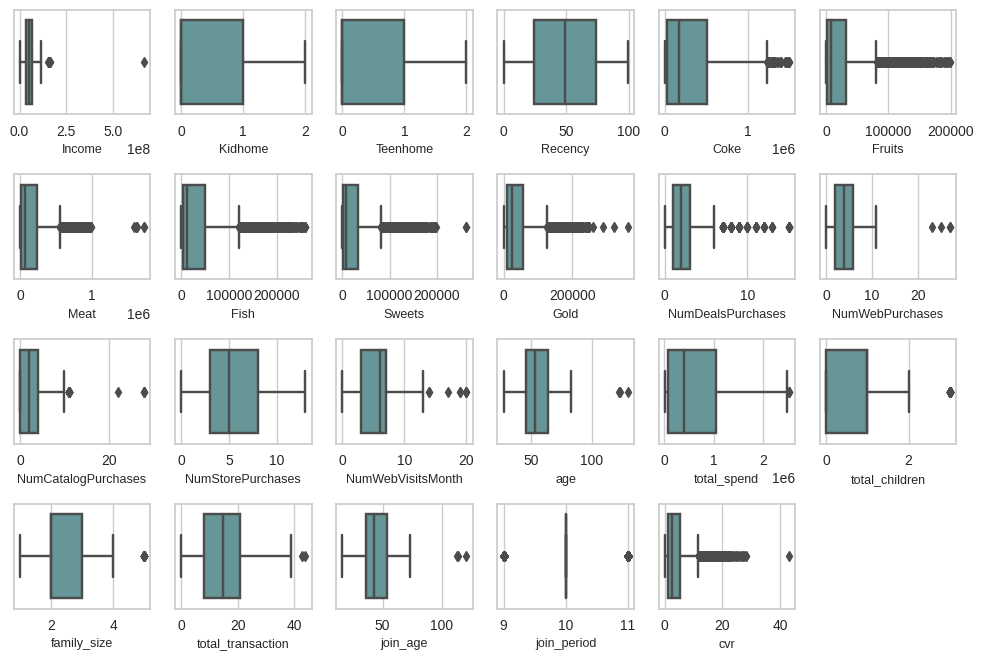

In [14]:
# Numerical Boxplot

plt.figure(figsize = (10, 8))

for i in range(0, len(nums)):
  plt.subplot(5, 6, i+1)
  sns.boxplot(x = df_eda[nums[i]], color = '#5F9EA0', orient = 'h')
  plt.xlabel(nums[i], fontsize = 9)
  plt.tight_layout()

plt.show()

In [15]:
# Numerical Kdeplot

plt.figure(figsize = (10, 8))

for i in range(0, len(nums)):
  plt.subplot(5, 6, i+1)
  sns.kdeplot(x = df_eda[nums[i]], color = '#5F9EA0')
  plt.xlabel(nums[i], fontsize = 9)
  plt.xticks(rotation = 90)
  plt.tight_layout()

plt.show()

In [16]:
# Categorical Countplot

plt.figure(figsize = (10, 10))

for i in range(0, len(cats)):
  plt.subplot(3, 4, i+1)
  sns.countplot(x = df_eda[cats[i]], color = '#5F9EA0')
  plt.xlabel(cats[i], fontsize = 9)
  plt.xticks(rotation = 45)
  plt.tight_layout()

plt.show()

### Mulrivariate Analysis

#### Correlation Plot

In [17]:
corrmat = df_eda.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corrmat,annot=True, cmap=sns.diverging_palette(220, 10, as_cmap=True), center=0)

<Axes: >

### Bivariate Analysis

#### Age vs CVR

In [18]:
style.use('ggplot')

x = df_eda['age']
y = df_eda['cvr']

ax = sns.jointplot(x = x,
                   y = y,
                   color = '#5F9EA0')

plt.xlabel('Age')
plt.ylabel('Conversion Rate (%)')


plt.grid(False)

plt.show()

#### Income vs CVR

In [19]:
# Dropping row with max value in income column including rows with the same value so the outliers is not to far

df_eda.drop(df_eda[df_eda['Income'] == df_eda['Income'].max()].index, inplace=True)

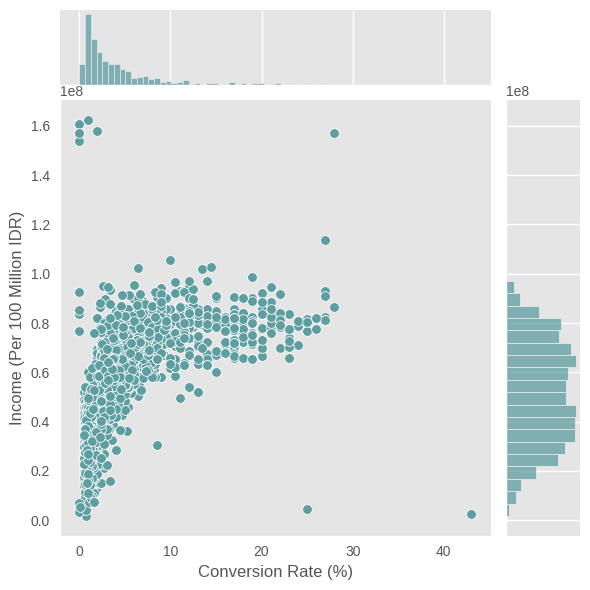

In [20]:
style.use('ggplot')

x = df_eda['cvr']
y = df_eda['Income']

ax = sns.jointplot(x = x,
                   y = y,
                   color = '#5F9EA0')

plt.xlabel('Conversion Rate (%)')
plt.ylabel('Income (Per 100 Million IDR)')


plt.grid(False)

plt.show()

#### Total Spend vs CVR

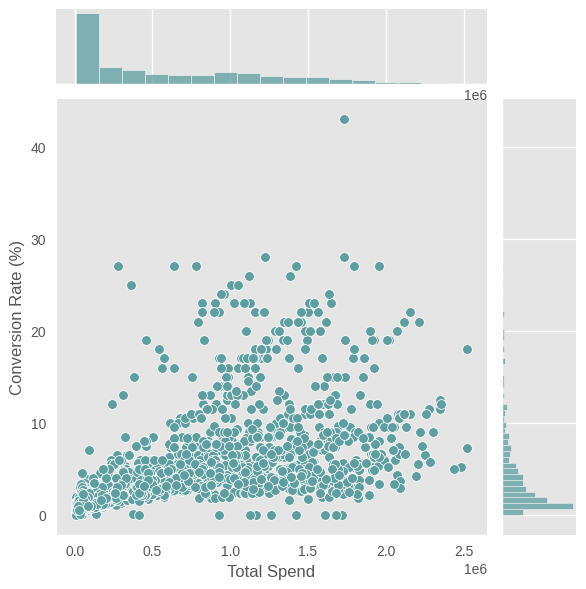

In [21]:
style.use('ggplot')

x = df_eda['total_spend']
y = df_eda['cvr']

ax = sns.jointplot(x = x,
                   y = y,
                   color = '#5F9EA0')

plt.xlabel('Total Spend')
plt.ylabel('Conversion Rate (%)')


plt.grid(False)

plt.show()

#### Income vs Total Spend

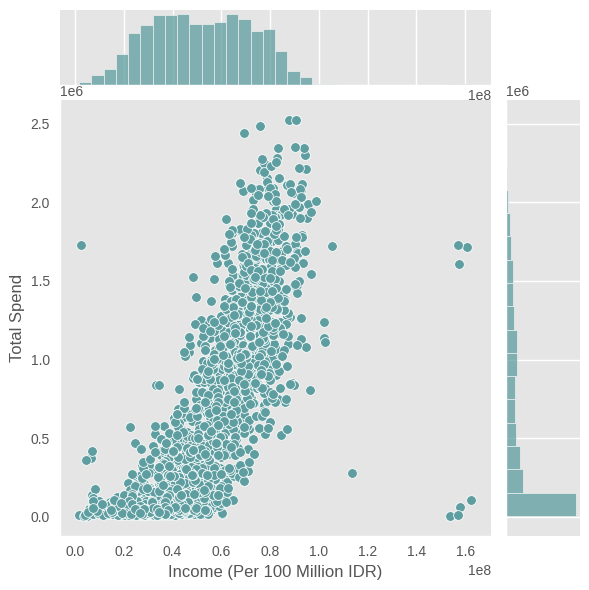

In [22]:
style.use('ggplot')

x = df_eda['Income']
y = df_eda['total_spend']

ax = sns.jointplot(x = x,
                   y = y,
                   color = '#5F9EA0')

plt.xlabel('Income (Per 100 Million IDR)')
plt.ylabel('Total Spend')


plt.grid(False)

plt.show()

#### Marital Status vs CVR

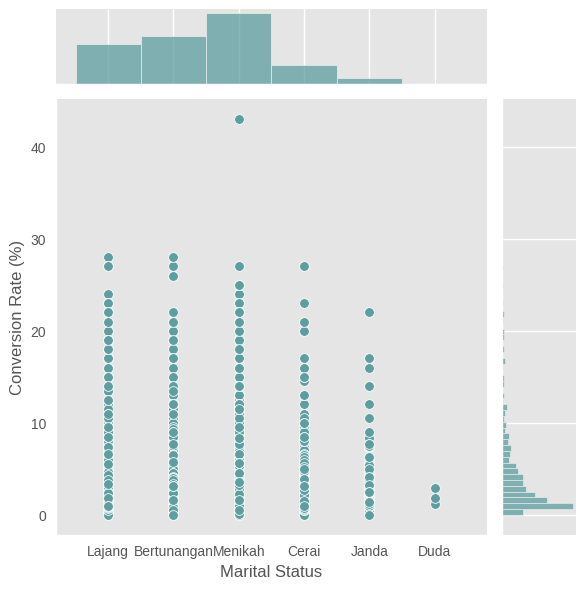

In [23]:
style.use('ggplot')

x = df_eda['Marital_Status']
y = df_eda['cvr']

ax = sns.jointplot(x = x,
                   y = y,
                   color = '#5F9EA0')

plt.xlabel('Marital Status')
plt.ylabel('Conversion Rate (%)')


plt.grid(False)

plt.show()

#### Recency vs CVR

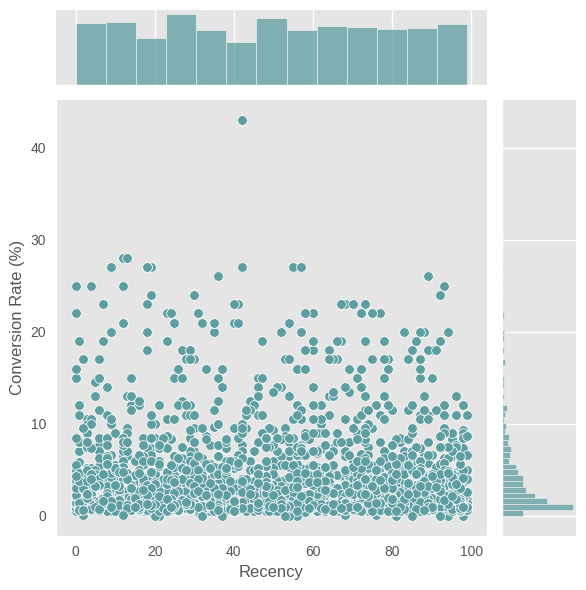

In [24]:
style.use('ggplot')

x = df_eda['Recency']
y = df_eda['cvr']

ax = sns.jointplot(x = x,
                   y = y,
                   color = '#5F9EA0')

plt.xlabel('Recency')
plt.ylabel('Conversion Rate (%)')


plt.grid(False)

plt.show()

# Data Preprocessing

## Handling Missing Values

In [25]:
df.isna().sum()

ID                      0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Recency                 0
Coke                    0
Fruits                  0
Meat                    0
Fish                    0
Sweets                  0
Gold                    0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Response                0
age                     0
total_spend             0
living_with             0
total_children          0
family_size             0
total_transaction       0
join_age                0
is_parent               0
age_group               0
join_period             0
cvr                     0
dtype: int64

There are 24 missing values in Income column. We will do an imputation to those missing values.

In [26]:
df.dropna(subset=['Income'], inplace=True)

In [27]:
df.isna().sum()

ID                     0
Education              0
Marital_Status         0
Income                 0
Kidhome                0
Teenhome               0
Recency                0
Coke                   0
Fruits                 0
Meat                   0
Fish                   0
Sweets                 0
Gold                   0
NumDealsPurchases      0
NumWebPurchases        0
NumCatalogPurchases    0
NumStorePurchases      0
NumWebVisitsMonth      0
AcceptedCmp3           0
AcceptedCmp4           0
AcceptedCmp5           0
AcceptedCmp1           0
AcceptedCmp2           0
Complain               0
Response               0
age                    0
total_spend            0
living_with            0
total_children         0
family_size            0
total_transaction      0
join_age               0
is_parent              0
age_group              0
join_period            0
cvr                    0
dtype: int64

## Handling Duplicates

In [28]:
df.duplicated().sum()

0

There is no duplicates in this dataset.

## Feature Selection

<Axes: >

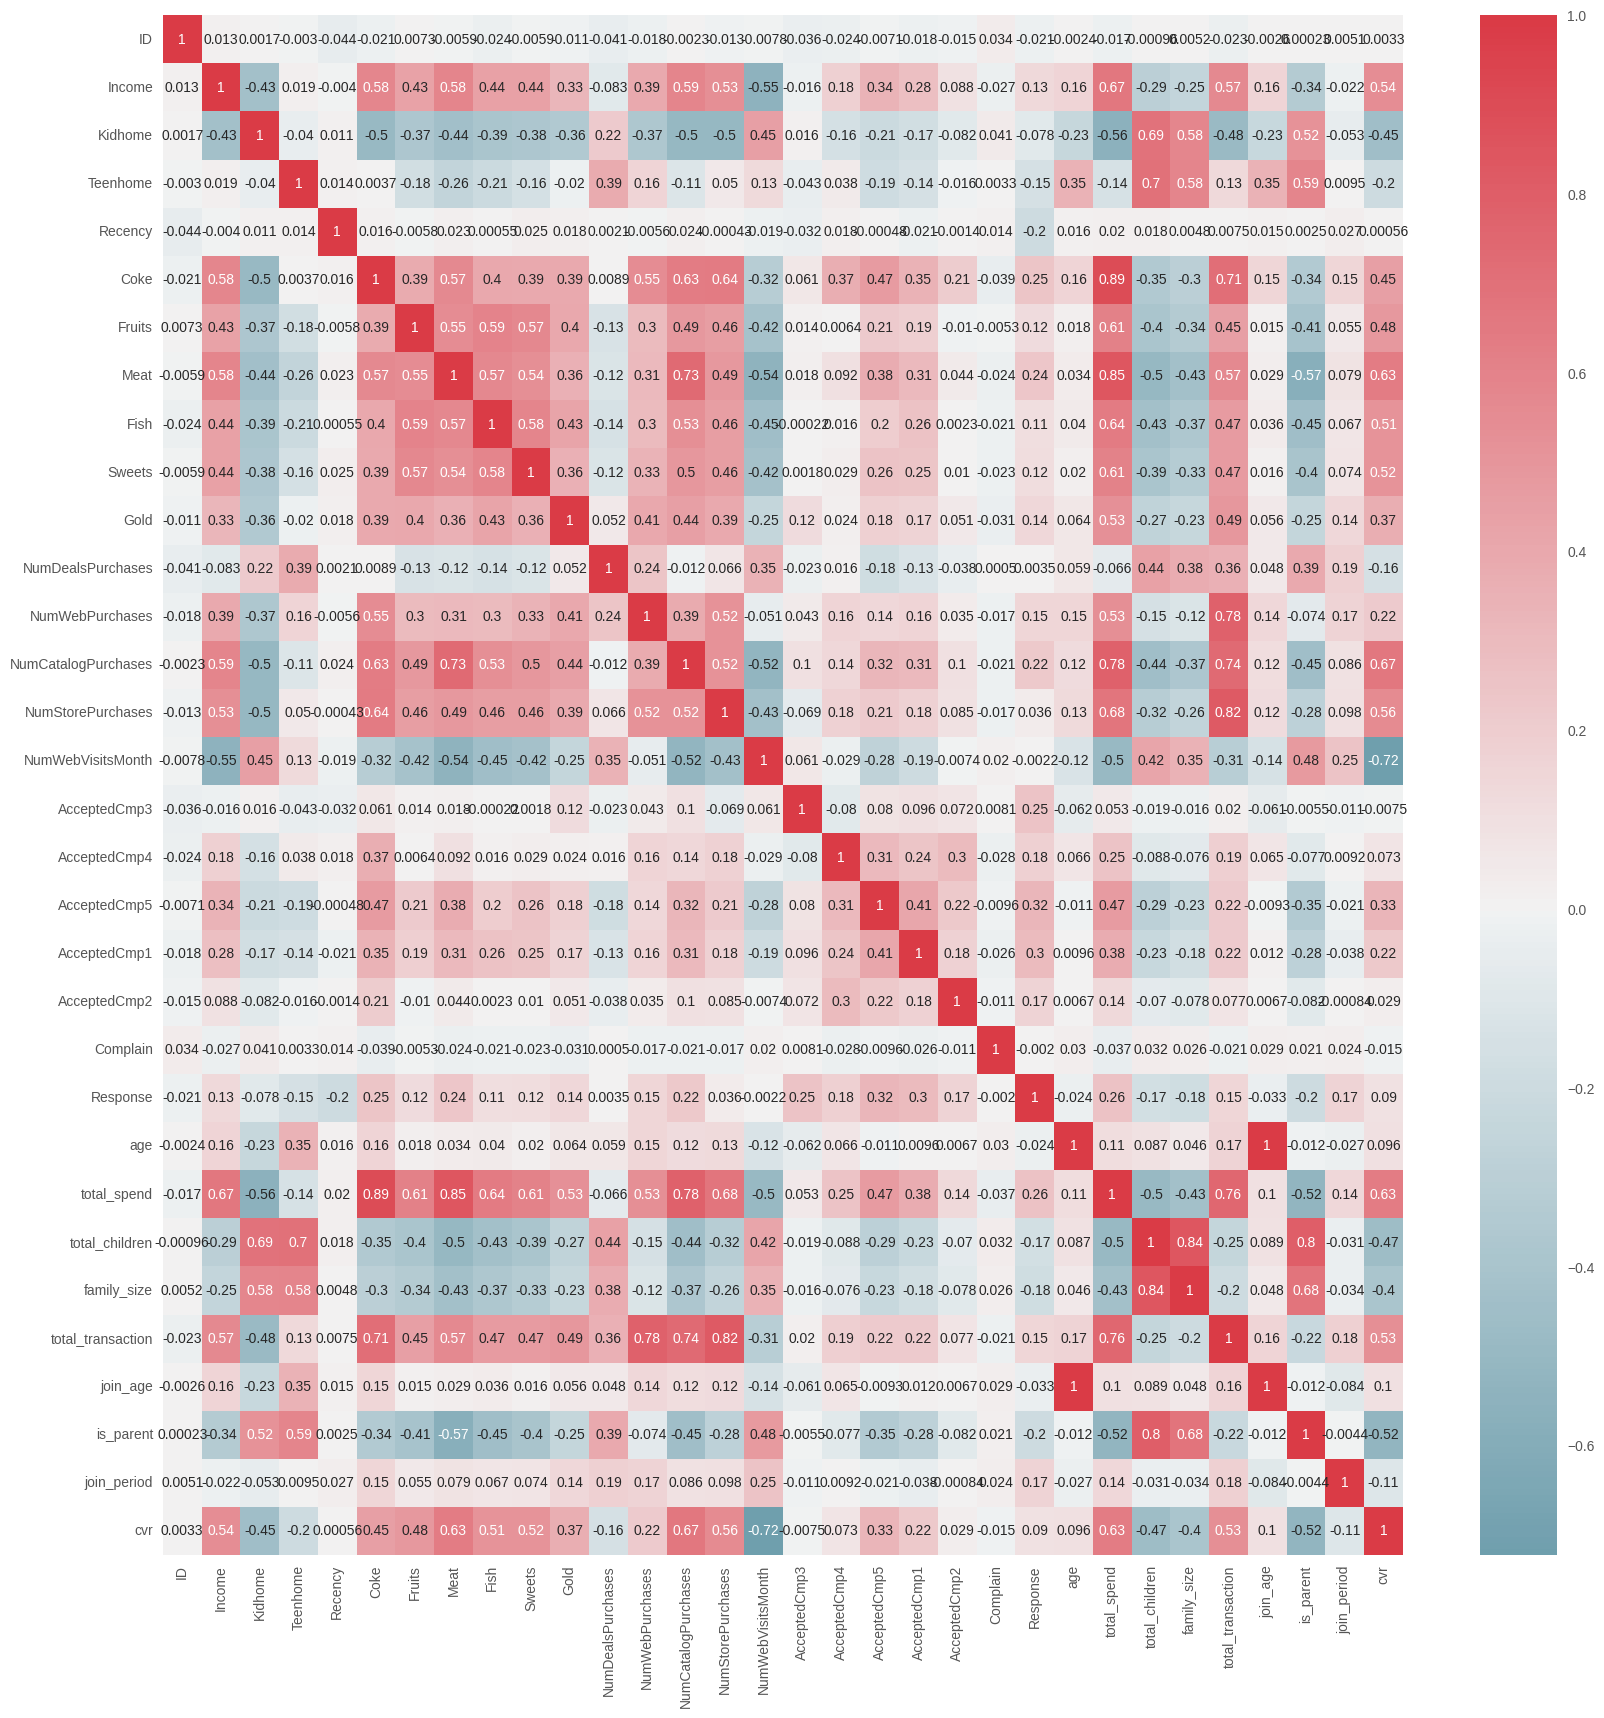

In [29]:
corrmat = df.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corrmat,annot=True, cmap=sns.diverging_palette(220, 10, as_cmap=True), center=0)

In [30]:
df.columns

Index(['ID', 'Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome',
       'Recency', 'Coke', 'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
       'Complain', 'Response', 'age', 'total_spend', 'living_with',
       'total_children', 'family_size', 'total_transaction', 'join_age',
       'is_parent', 'age_group', 'join_period', 'cvr'],
      dtype='object')

In [31]:
features = ['Education', 'Income', 'Kidhome', 'Teenhome', 'Recency',
            'Coke', 'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold','NumDealsPurchases',
            'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
            'NumWebVisitsMonth', 'AcceptedCmp3',
            'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
            'age', 'total_spend', 'living_with',
            'total_children', 'family_size', 'join_age',
            'is_parent', 'age_group', 'join_period']

df_fs = df[features]

## Feature Encoding

In [32]:
s = (df_fs.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables in the dataset:", object_cols)

Categorical variables in the dataset: ['Education', 'living_with', 'age_group']


In [33]:
mapping_education = {'SMA' : 0,
               'D3' : 1,
               'S1' : 2,
               'S2' : 3,
               'S3' : 4}

df_fs['Education'] = df_fs['Education'].map(mapping_education)

In [34]:
mapping_age = {'Young Adult' : 0,
               'Adult' : 1,
               'Senior' : 2}

df_fs['age_group'] = df_fs['age_group'].map(mapping_age)

In [35]:
prefix_living = pd.get_dummies(df_fs['living_with'], prefix = 'is')

df_fs = df_fs.join(prefix_living)

In [36]:
df_fs = df_fs.drop(['living_with'], axis = 1)

In [37]:
df_fs.sample(5)

Education      Income  Kidhome  Teenhome  Recency     Coke  Fruits  \
1010          2  77568000.0        0         1       30  1230000       0   
1023          3  33564000.0        0         1       51    61000       0   
912           4  52278000.0        0         1       24   953000       0   
1623          2  50664000.0        1         1       64   313000    8000   
47            2  41728000.0        1         0       92    13000    6000   

        Meat    Fish  Sweets  ...  age  total_spend  total_children  \
1010  396000  232000  178000  ...   44      2194000               1   
1023    3000       0       0  ...   57        71000               1   
912    71000       0       0  ...   60      1198000               1   
1623  104000    6000    4000  ...   64       561000               2   
47     15000    3000    5000  ...   55        55000               1   

      family_size  join_age  is_parent  age_group  join_period  is_Alone  \
1010            2        33          1          1           11         1   
1023            2        48          1          1            9         1   
912             2        50          1          1           10         1   
1623            3        54          1          2           10         1   
47              2        45          1          1           10         1   

      is_Partner  
1010           0  
1023           0  
912            0  
1623           0  
47             0  

[5 rows x 31 columns]

## Handling Outliers

In [38]:
df_fs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2216 entries, 0 to 2239
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Education            2216 non-null   int64  
 1   Income               2216 non-null   float64
 2   Kidhome              2216 non-null   int64  
 3   Teenhome             2216 non-null   int64  
 4   Recency              2216 non-null   int64  
 5   Coke                 2216 non-null   int64  
 6   Fruits               2216 non-null   int64  
 7   Meat                 2216 non-null   int64  
 8   Fish                 2216 non-null   int64  
 9   Sweets               2216 non-null   int64  
 10  Gold                 2216 non-null   int64  
 11  NumDealsPurchases    2216 non-null   int64  
 12  NumWebPurchases      2216 non-null   int64  
 13  NumCatalogPurchases  2216 non-null   int64  
 14  NumStorePurchases    2216 non-null   int64  
 15  NumWebVisitsMonth    2216 non-null   i

In [39]:
df_fs.columns

Index(['Education', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'Coke',
       'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold', 'NumDealsPurchases',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
       'AcceptedCmp1', 'AcceptedCmp2', 'age', 'total_spend', 'total_children',
       'family_size', 'join_age', 'is_parent', 'age_group', 'join_period',
       'is_Alone', 'is_Partner'],
      dtype='object')

In [40]:
out = ['Income', 'Kidhome', 'Teenhome', 'Recency', 'Coke',
       'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold', 'NumDealsPurchases',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth', 'age', 'total_spend', 'total_children',
       'family_size', 'join_age', 'join_period']

In [41]:
plt.figure(figsize = (10, 8))

for i in range(0, len(out)):
  plt.subplot(3, 7, i+1)
  sns.boxplot(x = df_fs[out[i]], color = '#5F9EA0', orient = 'h')
  plt.xlabel(out[i], fontsize = 9)
  plt.tight_layout()

plt.show()

We don't want to remove too many rows. Therefore, we just want to remove the irrelevant rows in 'age' column and too far outlier in 'Income' column. Then, the rest of the outliers if they are considered skewed, we will perform log transformation to those columns

In [42]:
# Remove too far outlier in Income column and Age that's already not relevant anymore

df_fs = df_fs[df_fs['age'] < 90]
df_fs.drop(df_fs[df_fs['Income'] == df_fs['Income'].max()].index, inplace=True)

print("The total number of data-points after removing the outliers are:", len(df_fs))

The total number of data-points after removing the outliers are: 2212


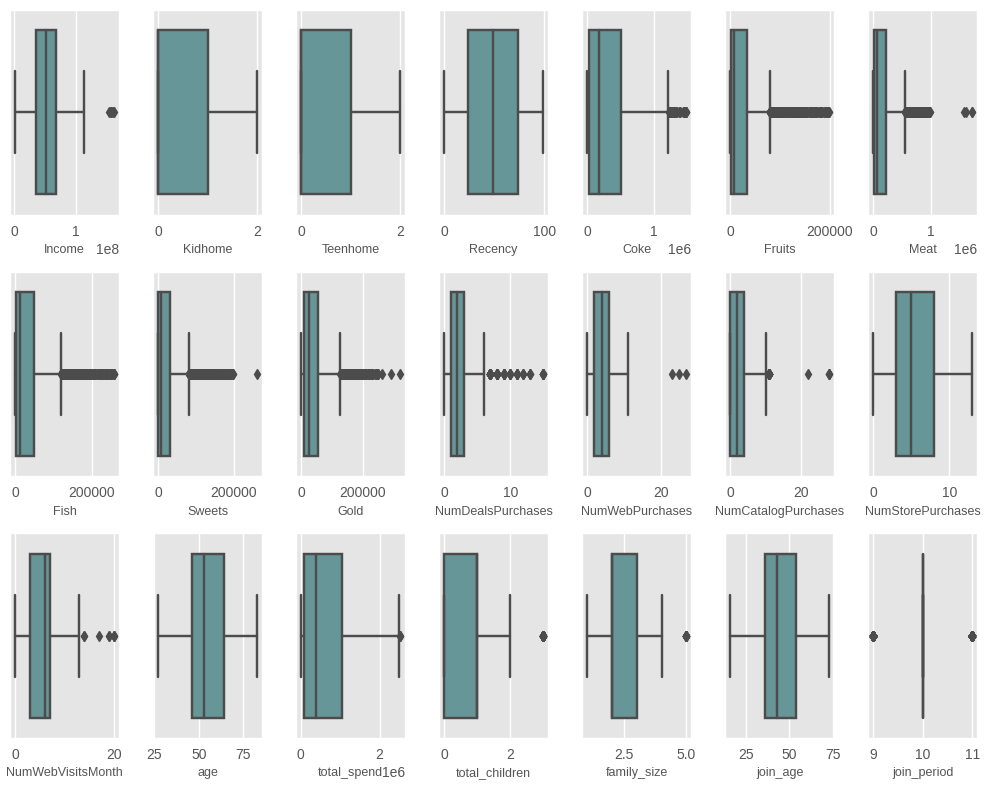

In [43]:
# Boxplot after outlier and irrelevant rows in Income and Age columns erased

plt.figure(figsize = (10, 8))

for i in range(0, len(out)):
  plt.subplot(3, 7, i+1)
  sns.boxplot(x = df_fs[out[i]], color = '#5F9EA0', orient = 'h')
  plt.xlabel(out[i], fontsize = 9)
  plt.tight_layout()

plt.show()

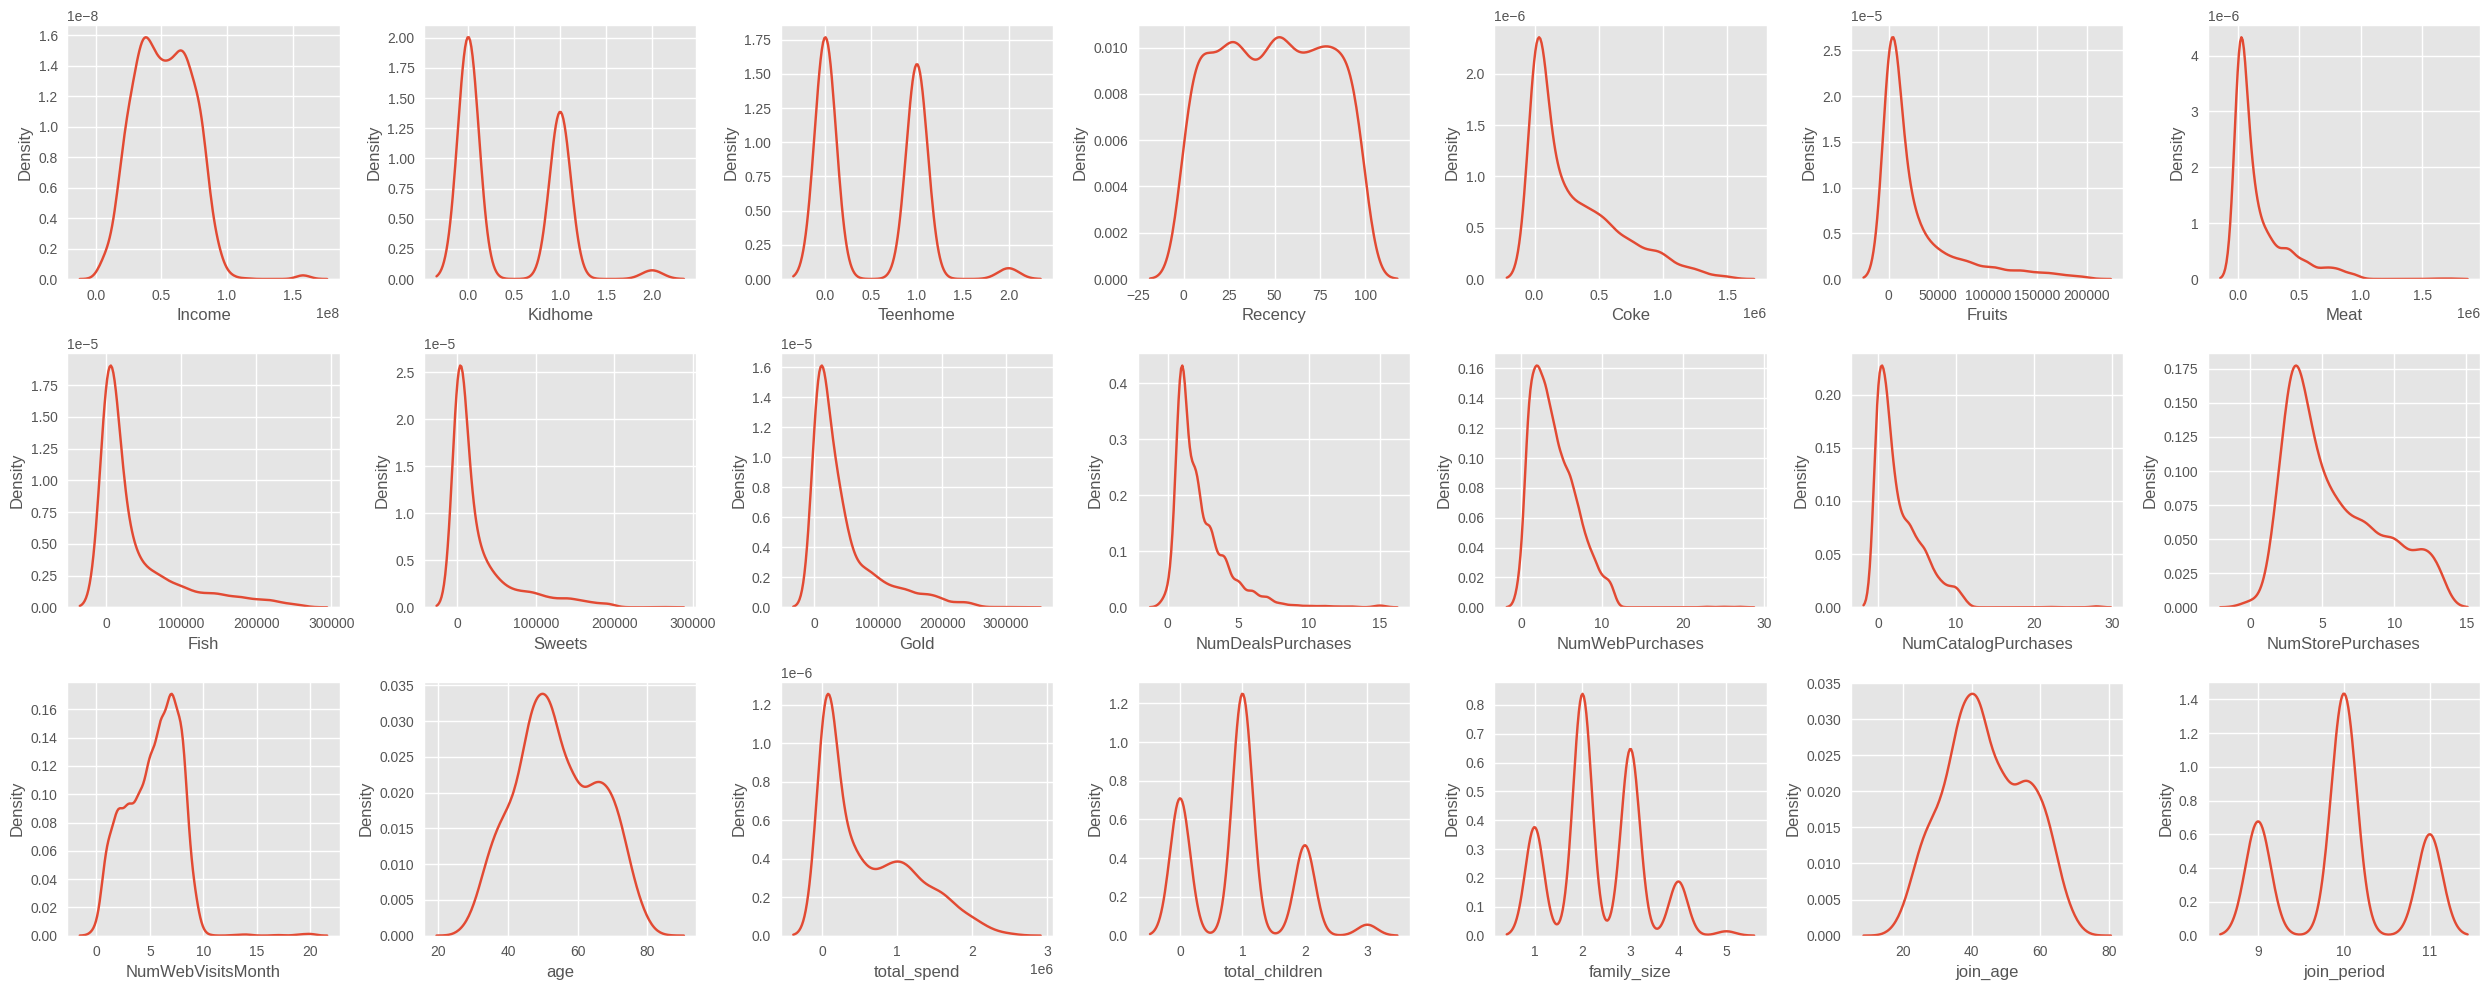

In [44]:
plt.figure(figsize=(25, 10))

for i in range(0, len(out)):
  plt.subplot(3, 7, i+1)
  sns.kdeplot(df_fs[out[i]])
  plt.tight_layout()

In [45]:
for i in range(0, len(out)):
  skew = df_fs[out[i]].skew(axis = 0, skipna = True)
  print(f'{out[i]}: {skew}')

Income: 0.34802798250785155
Kidhome: 0.6366277818507459
Teenhome: 0.4063285815207287
Recency: -0.0006879899616225997
Coke: 1.1709772460028438
Fruits: 2.1038642519812156
Meat: 2.027562968378447
Fish: 1.916558469843433
Sweets: 2.10292465758974
Gold: 1.8377281774611174
NumDealsPurchases: 2.4151853390898332
NumWebPurchases: 1.1953169915907484
NumCatalogPurchases: 1.8815233009735006
NumStorePurchases: 0.6997147056352482
NumWebVisitsMonth: 0.21804020948415848
age: 0.09340685803317067
total_spend: 0.8573824503079088
total_children: 0.40831118749453565
family_size: 0.2732163219545106
join_age: 0.09318877153296483
join_period: 0.03579902105635408


According to [simplilearn.com](https://www.simplilearn.com/tutorials/statistics-tutorial/skewness-and-kurtosis) website, if skewness is between -0.5 and 0.5, the distribution is approximately symmetric.Therefore, log transformation will be performed on these columns:
- Kidhome
- Coke
- Fruits
- Meat
- Fish
- Sweets
- Gold
- NumDealsPurchases
- NumWebPurchases
- NumCatalogPurchases
- NumStorePurchases
- total_spend



In [46]:
log = ['Kidhome', 'Coke',  'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold', 'NumDealsPurchases',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'total_spend']

df_log = df_fs.copy()

In [47]:
# Log Transformation
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method = 'yeo-johnson')

for i in range(0, len(log)):
  df_log[log[i]] = pt.fit_transform(df_log[[log[i]]])

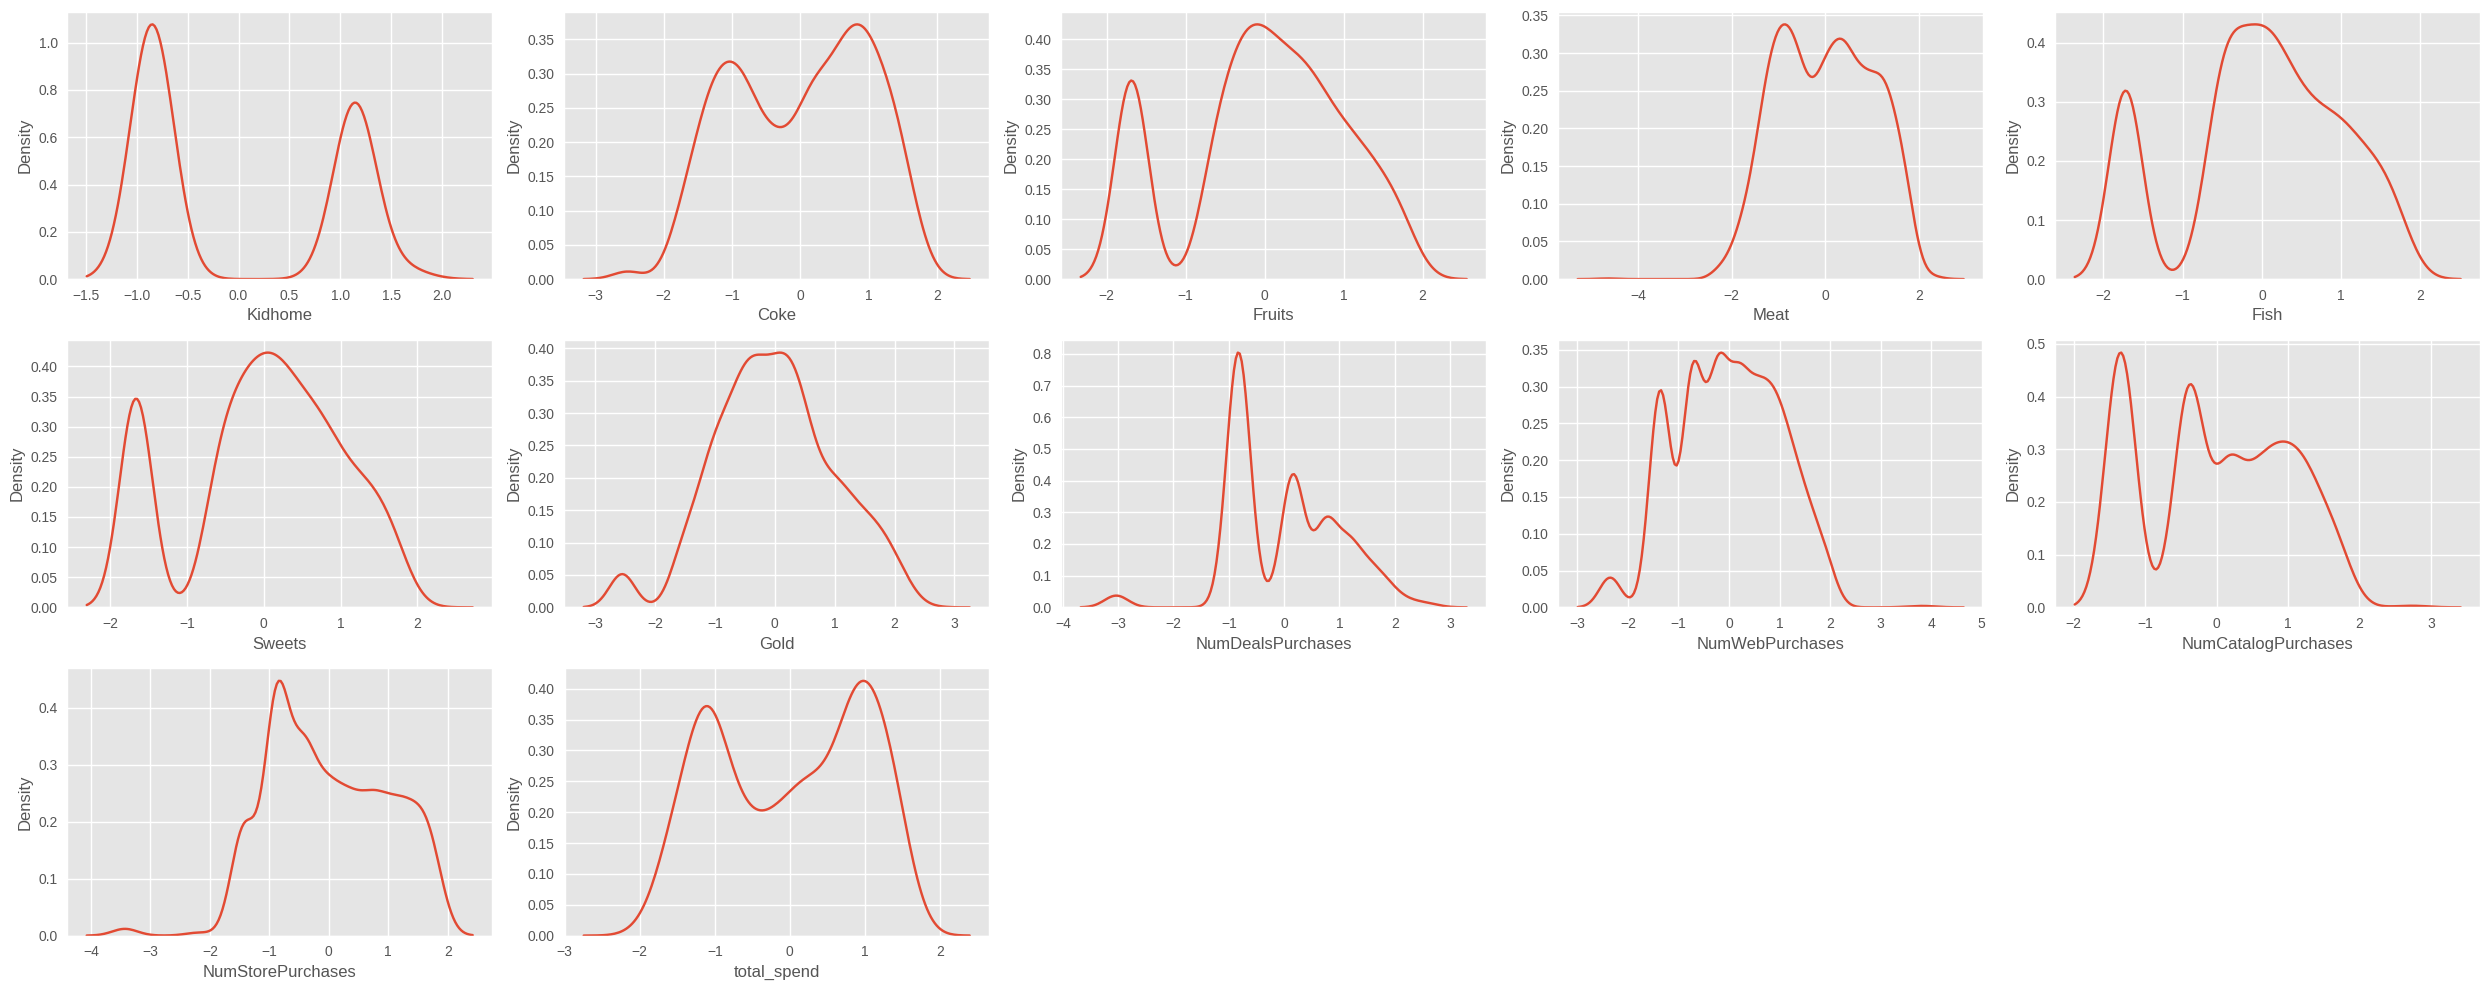

In [48]:
plt.figure(figsize=(25, 10))

for i in range(0, len(log)):
  plt.subplot(3, 5, i+1)
  sns.kdeplot(df_log[log[i]])
  plt.tight_layout()

In [49]:
for i in range(0, len(log)):
  skew = df_log[log[i]].skew(axis = 0, skipna = True)
  print(f'{log[i]}: {skew}')

Kidhome: 0.33898394319308156
Coke: -0.16995040264546996
Fruits: -0.30140657275978144
Meat: -0.03241963150925424
Fish: -0.3194129089757651
Sweets: -0.3087640853348823
Gold: -0.04127156655020795
NumDealsPurchases: 0.0007692487053193961
NumWebPurchases: -0.01983661293160151
NumCatalogPurchases: 0.029443276636029858
NumStorePurchases: -0.006571493632482597
total_spend: -0.12437899800669502


Now the skewness of the feature can be considered normal.

In [50]:
df_log.sample(5)

Education      Income   Kidhome  Teenhome  Recency      Coke    Fruits  \
934           2  75127000.0 -0.850280         0       92  0.209498  0.765191   
721           2  59111000.0 -0.850280         0       90  0.894024 -1.685965   
2138          3  62637000.0 -0.850280         1       76 -0.193952  0.230475   
1265          2  83829000.0 -0.850280         0       78  1.350708  1.752165   
1585          4  35860000.0  1.144526         1       37 -1.075825 -1.685965   

          Meat      Fish    Sweets  ...  age  total_spend  total_children  \
934   1.014800  0.705363  0.394009  ...   71     0.717002               0   
721   0.458718  0.441604  0.638777  ...   69     0.752960               0   
2138 -0.188165 -0.368295  0.236573  ...   69    -0.397808               1   
1265  1.257560  1.609316  1.708823  ...   48     1.450191               0   
1585 -1.202511 -0.368295 -0.425572  ...   50    -1.158518               2   

      family_size  join_age  is_parent  age_group  join_period  is_Alone  \
934             1        62          0          2            9         1   
721             2        59          0          2           10         0   
2138            2        60          1          2            9         1   
1265            1        38          0          1           10         1   
1585            3        41          1          1            9         1   

      is_Partner  
934            0  
721            1  
2138           0  
1265           0  
1585           0  

[5 rows x 31 columns]

## Standardization

In [51]:
#Creating a copy of data
ds = df_log.copy()
# creating a subset of dataframe by dropping the features on deals accepted and promotions
cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2']
ds = ds.drop(cols_del, axis=1)
#Scaling
scaler = StandardScaler()
scaler.fit(ds)
df_std = pd.DataFrame(scaler.transform(ds),columns= ds.columns )
print("All features are now scaled")

All features are now scaled


In [52]:
print('Dataframe to be used for further modeling')
df_std.sample(5)

Dataframe to be used for further modeling


Education    Income   Kidhome  Teenhome   Recency      Coke    Fruits  \
1402  -0.458850  0.550644 -0.850280  0.908097 -0.138905  1.428410  0.230475   
1484   1.533251 -0.106485 -0.850280 -0.929699 -0.484488  1.606217  0.605200   
397   -0.458850 -0.233980  1.144526 -0.929699  1.416220 -0.304399  0.894922   
657   -0.458850  1.179895 -0.850280  0.908097 -0.380813  0.413232  1.070029   
18    -1.454900 -0.843159  1.144526 -0.929699  1.277987 -1.494131  0.392220   

          Meat      Fish    Sweets  ...       age  total_spend  \
1402  0.885337  0.174747  0.236573  ...  0.249052     1.158491   
1484  0.386731  0.202200  0.271824  ...  1.189307     1.175265   
397  -0.116499  1.188723  1.221451  ... -1.545980     0.076154   
657   0.312569  0.941616  1.387490  ... -0.947636     0.536241   
18   -0.730131  0.476674  0.560636  ... -1.375024    -0.604213   

      total_children  family_size  join_age  is_parent  age_group  \
1402        0.069987    -0.371689  0.160677   0.632456  -0.640366   
1484       -1.264598    -1.481237  1.098005  -1.581139   1.467505   
397         0.069987    -0.371689 -1.628768   0.632456  -0.640366   
657         0.069987     0.737859 -0.947074   0.632456  -0.640366   
18          0.069987    -0.371689 -1.458344   0.632456  -0.640366   

      join_period  is_Alone  is_Partner  
1402     1.499086  0.795281   -0.795281  
1484     1.499086  0.795281   -0.795281  
397      1.499086  0.795281   -0.795281  
657      0.040872 -1.257417    1.257417  
18       1.499086  0.795281   -0.795281  

[5 rows x 26 columns]

# Dimensionality Reduction

In [53]:
#Initiating PCA to reduce dimentions aka features to 2
pca = PCA(n_components=2)
pca.fit(df_std)
df_pca = pd.DataFrame(pca.transform(df_std), columns=(['pc1','pc2']))
df_pca.describe().T

count          mean       std       min       25%       50%       75%  \
pc1  2212.0 -1.220643e-16  3.006208 -5.817554 -2.683642  0.090987  2.748670   
pc2  2212.0  5.139550e-17  1.923103 -5.348313 -1.559877  0.033278  1.472545   

          max  
pc1  7.628083  
pc2  5.809388

# Unsupervised Machine Learning: Clustering

## Determine the Number of Cluster Using Elbow Method

Elbow Method to determine the number of clusters to be formed:


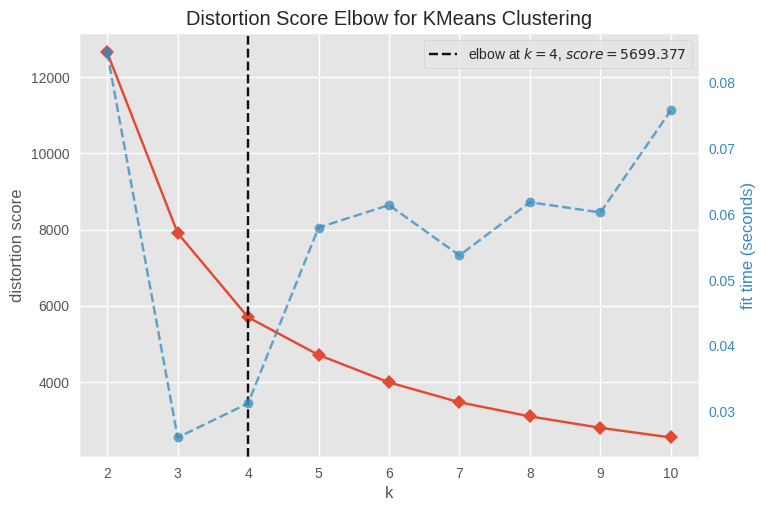

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [54]:
# Quick examination of elbow method to find numbers of clusters to make.
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(df_pca)
Elbow_M.show()

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(df_pca)
df_pca['clusters'] = kmeans.labels_
df_fs['clusters'] = kmeans.labels_

In [ ]:
style.use('ggplot')

fig, ax = plt.subplots(figsize = (12, 6))

sns.scatterplot(data = df_pca, x = 'pc1', y = 'pc2', hue = 'clusters',
                edgecolor = 'white', linestyle = '--', palette =['#5F9EA0', '#E9967A', '#8FBC8F', '#FFA500', '#DC143C'],
                s = 100,
                ax = ax)

plt.title('Clustering of Customer Type', loc = 'left', fontweight = 'bold')

Text(0.0, 1.0, 'Clustering of Customer Type')

# Evaluating Model

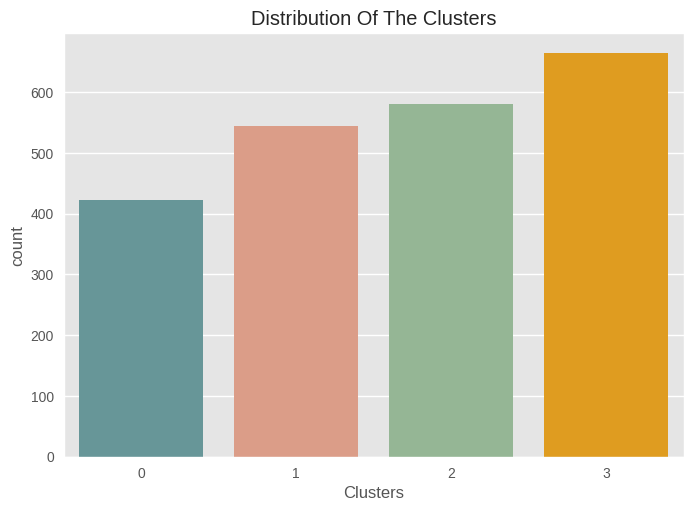

In [ ]:
#Plotting countplot of clusters
pal = ['#5F9EA0', '#E9967A', '#8FBC8F', '#FFA500', '#DC143C']
pl = sns.countplot(x=df_fs["clusters"], palette= pal)
pl.set_title("Distribution Of The Clusters")

plt.xlabel('Clusters')

plt.show()

The clusters are fairly distributed.


In [ ]:
pl = sns.scatterplot(data = df_fs,x=df_fs["total_spend"], y=df_fs["Income"],hue=df_fs["clusters"], palette= pal)
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.xlabel('Total Spend')
plt.legend()
plt.show()

0: Average Income & Low Spend

1: High Income & High Spend

2: Low Income & Low Spend

3: High Income & Average Spend

Next, we will be looking at the detailed distribution of clusters as per the various products in the data. Namely: Wines, Fruits, Meat, Fish, Sweets and Gold

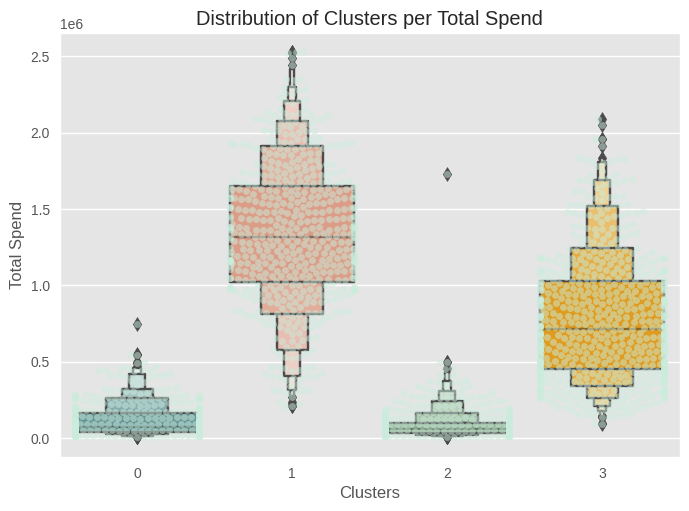

In [ ]:
plt.figure()
pl=sns.swarmplot(x=df_fs["clusters"], y=df_fs["total_spend"], color= "#CBEDDD", alpha=0.5 )
pl=sns.boxenplot(x=df_fs["clusters"], y=df_fs["total_spend"], palette=pal)

plt.title('Distribution of Clusters per Total Spend')
plt.xlabel('Clusters')
plt.ylabel('Total Spend')
plt.show()

From the above plot, it can be seen that cluster 1 is our biggest set of customers closely followed by cluster 3. We can explore what each cluster is spending on for the targeted marketing strategies.

In [ ]:
#Creating a feature to get a sum of accepted promotions
df_fs["cmp_accepted"] = df_fs["AcceptedCmp1"]+ df_fs["AcceptedCmp2"]+ df_fs["AcceptedCmp3"]+ df_fs["AcceptedCmp4"]+ df_fs["AcceptedCmp5"]

#Plotting count of total campaign accepted.

plt.figure()
pl = sns.countplot(x=df_fs["cmp_accepted"],hue=df_fs["clusters"], palette= pal)
pl.set_title("Count Of Promotion Accepted")
pl.set_xlabel("Number Of Total Accepted Promotions")
plt.show()

There has not been an overwhelming response to the campaigns so far. Very few participants overall. Moreover, no one part take in all 5 of them. Perhaps better-targeted and well-planned campaigns are required to boost sales.

In [ ]:
#Plotting the number of deals purchased
plt.figure()
pl=sns.boxenplot(y=df_fs["NumDealsPurchases"],x=df_fs["clusters"], palette= pal)
pl.set_title("Number of Deals Purchased")
plt.show()

Unlike campaigns, the deals offered did well. It has best outcome with cluster 3 and 0. However, our star customers cluster 1 are not much into the deals.

# Profiling

<Figure size 800x550 with 0 Axes>

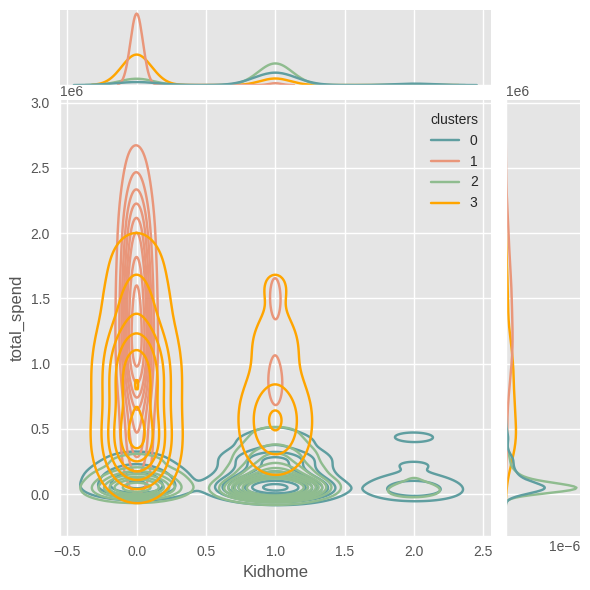

<Figure size 800x550 with 0 Axes>

<Figure size 800x550 with 0 Axes>

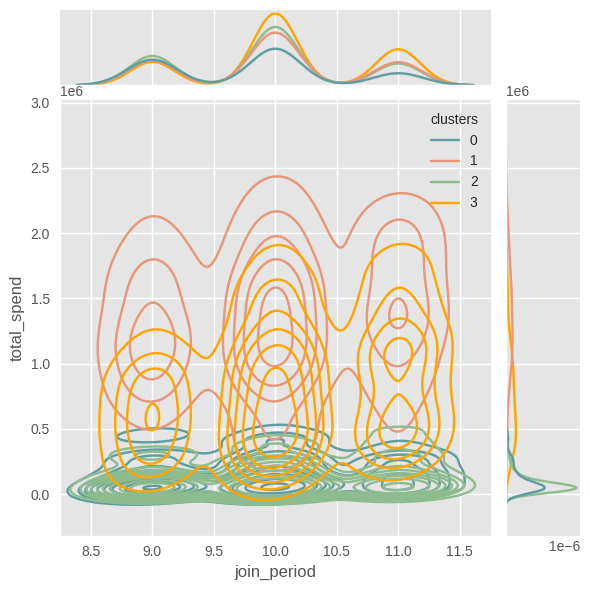

<Figure size 800x550 with 0 Axes>

<Figure size 800x550 with 0 Axes>

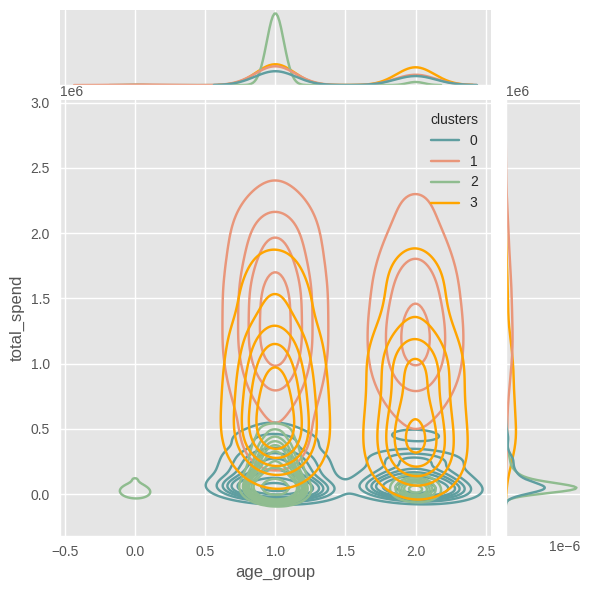

<Figure size 800x550 with 0 Axes>

<Figure size 800x550 with 0 Axes>

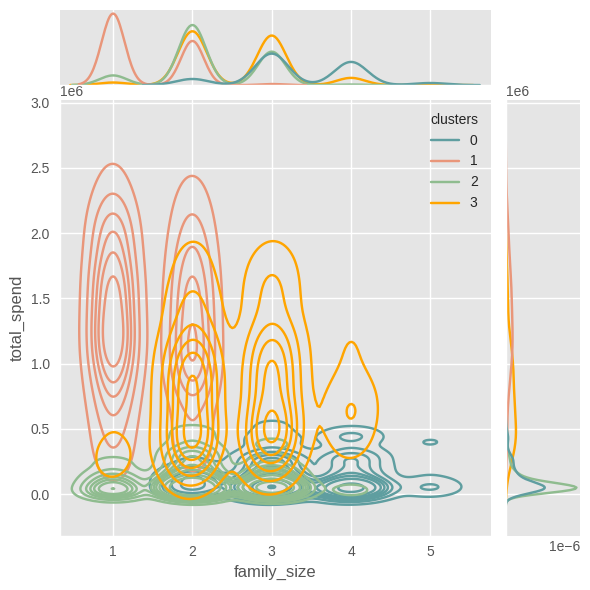

<Figure size 800x550 with 0 Axes>

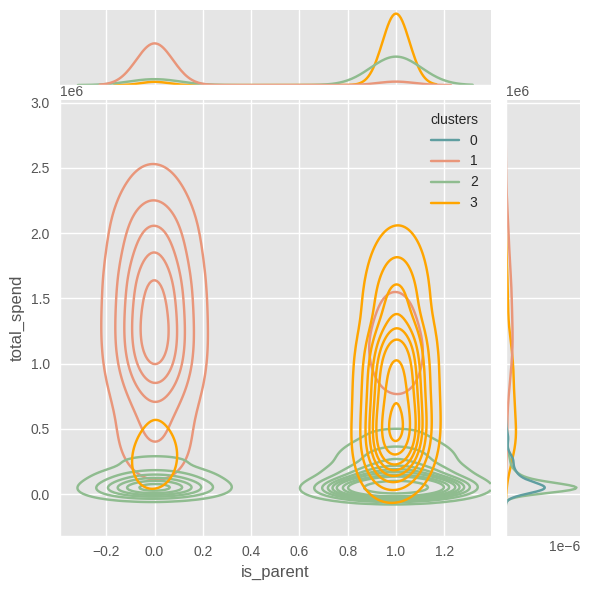

<Figure size 800x550 with 0 Axes>

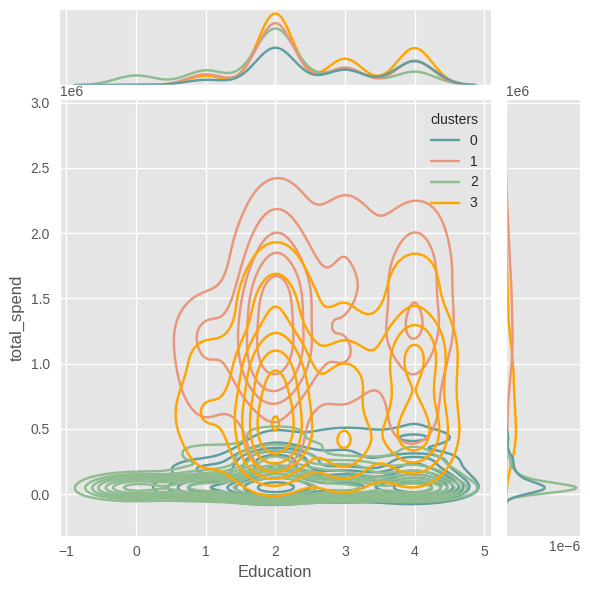

In [ ]:
Personal = [ "Kidhome","Teenhome","join_period", "age", "age_group", "total_children", "family_size", "is_parent", "Education"]

for i in Personal:
    plt.figure()
    sns.jointplot(x=df_fs[i], y=df_fs["total_spend"], hue =df_fs["clusters"], kind="kde", palette=pal)
    plt.show()

Points to be noted:

The following information can be deduced about the customers in different clusters.

1.   **Group 0**

  *   Definitely a parent with 1 kid and/or 1 teen.
  *   Whether an adult or senior. But mostly adults.
  *   Majority has 2 children and some has 3.
  *   Household capacity mainly 4 and some has 5 family members.


2.   **Group 1**

  *   Not a parent.
  *   Whether an adult or senior.
  *   Majority live alone and some has 2 members in the household.

3.   **Group 2**

  *   Majority is a parent with 1 or 2 children.
  *   Majority has a kid in the house.
  *   Span in all ages but mainly an adult.
  *   Member of the household are mainly 2, with the maximum of 4.

4.   **Group 3**

  *   Definitely a parent, with a majority of a teen in the house.
  *   Whether an adult or senior
  *   Mainly have just 1 child
  *   Mainly have 2 or 3 family members, and some have 4.
